# Understanding quality and accuracy -- step 3
Modifying James Requa's Kaggle notebook: https://www.kaggle.com/jamesrequa/keras-k-fold-inception-v3-1st-place-lb-0-99770/notebook

In [1]:
nb_version = "UD" # notebook version: Understanding_D

In [2]:
import glob
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib
from matplotlib import pylab, mlab
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize, getfigs
#from pylab import *
#from numpy import *
%matplotlib inline
import matplotlib.image as mpimg
from sklearn.utils import shuffle

Using TensorFlow backend.


# Data
We need to prepare the data to be labelled correctly and input properly into our model.

In [3]:
path = '../../data/1-pre-processed/C'
colon_normal   = glob.glob(path+'/Normal/*.jpg')
colon_abnormal = glob.glob(path+'/Abnormal/*.jpg')
dfn = pd.DataFrame()
dfa = pd.DataFrame()
dfn['filepath'] = colon_normal
dfa['filepath'] = colon_abnormal
dfn['abnormality'] = 0
dfa['abnormality'] = 1
splitPoint = int(0.8*len(colon_abnormal))
print(f'splitPoint = {splitPoint}')
n_train = dfn[:splitPoint]
n_test  = dfn[splitPoint:]
a_train = dfa[:splitPoint]
a_test  = dfa[splitPoint:]
df_train = pd.concat([n_train,a_train])
df_test  = pd.concat([n_test,a_test])
df_train = shuffle(df_train).reset_index(drop=True)
df_test  = shuffle(df_test).reset_index(drop=True)

train_set    = df_train
train_labels = np.array(train_set['abnormality'].iloc[: ])
train_files  = df_train['filepath'].tolist()

test_set    = df_test
test_labels = np.array(test_set['abnormality'].iloc[: ])
test_files  = df_test['filepath'].tolist()

print(train_set.head())
print(test_set.head())

print(f'\nTrain distribution:\n{train_set["abnormality"].value_counts()}')
print(f'\nTest distribution:\n{test_set["abnormality"].value_counts()}')

splitPoint = 80
                                            filepath  abnormality
0  ../../data/1-pre-processed/C/Abnormal/9092882 ...            1
1  ../../data/1-pre-processed/C/Normal/2508121 04...            0
2  ../../data/1-pre-processed/C/Normal/2404882 20...            0
3  ../../data/1-pre-processed/C/Abnormal/9092882 ...            1
4  ../../data/1-pre-processed/C/Abnormal/9092882 ...            1
                                            filepath  abnormality
0  ../../data/1-pre-processed/C/Abnormal/9092882 ...            1
1  ../../data/1-pre-processed/C/Normal/2537954 30...            0
2  ../../data/1-pre-processed/C/Abnormal/9092882 ...            1
3  ../../data/1-pre-processed/C/Normal/2404882 20...            0
4  ../../data/1-pre-processed/C/Abnormal/9092882 ...            1

Train distribution:
1    80
0    80
Name: abnormality, dtype: int64

Test distribution:
1    20
0    20
Name: abnormality, dtype: int64


In [4]:
n_train.iloc[0][0]

'../../data/1-pre-processed/C/Normal/2537954 30 Dec 18_1 00942.jpg'

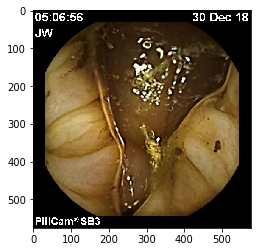

type(img) = <class 'numpy.ndarray'>
img.shape = (576, 576, 3)
          = (img_height, img_width, img_channels)


In [5]:
img = mpimg.imread(n_train.iloc[0][0])
imgplot = plt.imshow(img)
plt.show()
print(f'type(img) = {type(img)}')
print(f'img.shape = {img.shape}')
print( "          = (img_height, img_width, img_channels)")

img_height = img.shape[0]
img_width = img.shape[1]
img_channels = img.shape[2]
img_shape = (img_height, img_width, img_channels)
img_size  = (img_height, img_width)

# Model
We need to define, compile, train, and test our model.  (We'll put the `compile` part in the `train_model` function.)

In [6]:
def mobilenet_v2_a(img_dim=img_shape):
    # base network to be built around:
    base_model = MobileNetV2(input_shape=None,
                             #input_shape=img_dim,
                             alpha=1.0,
                             depth_multiplier=1,
                             include_top=False,
                             weights='imagenet',
                             input_tensor=None,
                             pooling=None
                             #classes=1000
                            )
    for layer in base_model.layers:
        layer.trainable = False
    #for layer in base_model.layers[:153]:
    #    layer.trainable = False
    #for layer in base_model.layers[153:]:
    #    layer.trainable = True

    xi = Input(shape=img_dim)              # input tensor
    x  = BatchNormalization()(xi)          # next layer
    x  = base_model(x)                     # Each x on the right refers to
    x  = Dropout(0.5)(x)                   #  the previous x on the left.
    x  = Flatten()(x)                      # 
    xo = Dense(1, activation='sigmoid')(x) # output tensor
    model = Model(inputs=xi, outputs=xo, name='mobilenet_v2_a')
    return model

model = mobilenet_v2_a()

print(f'model name: {model.name}')
model.summary()
# model.name    # (a string, the name of the model)
# model.summary # (a printout summarizing the model)
# model.layers  # (a set of layer objects?)
# model.inputs  # (a [set of] tensor objects)
# model.outputs # (a [set of] tensor objects)

/Users/zero/Tools/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:306: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


model name: mobilenet_v2_a
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 576, 576, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 576, 576, 3)       12        
_________________________________________________________________
mobilenetv2_1.00_224 (Model) multiple                  2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 1280)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 414720)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 414721    
Total params: 2,672,717
Trainable params: 414,727
Non-trainable params: 2,257,990
_________________________________

In [7]:
def train_model(input_model, batch_size, epochs, img_size,
                x, y, test, n_fold, kf, nb_v):

    roc_auc      = metrics.roc_auc_score
    preds_train  = np.zeros(len(x), dtype = np.float)
    preds_test   = np.zeros(len(test), dtype = np.float)
    train_scores = []; valid_scores = []

    # "Fold" counter
    i = 1

    for train_index, test_index in kf.split(x):
        x_train = x.iloc[train_index]; x_valid = x.iloc[test_index]
        y_train = y[train_index]; y_valid = y[test_index]

        def augment(src, choice):
            if choice == 0:
                # Rotate 90
                src = np.rot90(src, 1)
            if choice == 1:
                # flip vertically
                src = np.flipud(src)
            if choice == 2:
                # Rotate 180
                src = np.rot90(src, 2)
            if choice == 3:
                # flip horizontally
                src = np.fliplr(src)
            if choice == 4:
                # Rotate 90 counter-clockwise
                src = np.rot90(src, 3)
            if choice == 5:
                # Rotate 180 and flip horizontally
                src = np.rot90(src, 2)
                src = np.fliplr(src)
            return src

        def train_generator():
            while True:
                for start in range(0, len(x_train), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(x_train))
                    train_batch = x_train[start:end]
                    for filepath, tag in train_batch.values:
                        img = cv2.imread(filepath)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, img_size)
                        img = augment(img, np.random.randint(6))
                        x_batch.append(img)
                        y_batch.append(tag)
                    x_batch = np.array(x_batch, np.float32) / 255.
                    y_batch = np.array(y_batch, np.uint8)
                    yield x_batch, y_batch

        def valid_generator():
            while True:
                for start in range(0, len(x_valid), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(x_valid))
                    valid_batch = x_valid[start:end]
                    for filepath, tag in valid_batch.values:
                        img = cv2.imread(filepath)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, img_size)
                        #img = augment(img, np.random.randint(6))
                        x_batch.append(img)
                        y_batch.append(tag)
                    x_batch = np.array(x_batch, np.float32) / 255.
                    y_batch = np.array(y_batch, np.uint8)
                    yield x_batch, y_batch

        def test_generator():
            while True:
                for start in range(0, len(test), batch_size):
                    x_batch = []
                    end = min(start + batch_size, len(test))
                    test_batch = test[start:end]
                    for filepath in test_batch:
                        img = cv2.imread(filepath)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, img_size)
                        x_batch.append(img)
                    x_batch = np.array(x_batch, np.float32) / 255.
                    yield x_batch

        train_steps = len(x_train) / batch_size
        valid_steps = len(x_valid) / batch_size
        test_steps = len(test) / batch_size

        model = input_model

        callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
                     ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=1,
                                       verbose=1, min_lr=1e-7),
                     ModelCheckpoint(filepath = f'./weights/{model.name}/{nb_v}/chkpt_fold_{str(i)}.hdf5',
                                     verbose=1, save_best_only=True, save_weights_only=True, mode='auto'),
                     TensorBoard(log_dir = f'./tb_logs/{model.name}/{nb_v}/tb_fold_{str(i)}/' )
                    ]

        model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy',
                      metrics = ['accuracy'])        

        model.fit_generator(train_generator(), train_steps, epochs=epochs, verbose=1,
                            callbacks=callbacks, validation_data=valid_generator(),
                            validation_steps=valid_steps)

        model.load_weights(filepath = f'./weights/{model.name}/{nb_v}/weights_fold_{str(i)}.hdf5' )

        print('Running validation predictions on fold {}'.format(i))
        preds_valid = model.predict_generator(generator=valid_generator(),
                                              steps=valid_steps, verbose=1)[:, 0]

        print('Running train predictions on fold {}'.format(i))
        preds_train = model.predict_generator(generator=train_generator(),
                                              steps=train_steps, verbose=1)[:, 0]

        valid_score = roc_auc(y_valid, preds_valid)
        train_score = roc_auc(y_train, preds_train)
        print('Val Score:{} for fold {}'.format(valid_score, i))
        print('Train Score: {} for fold {}'.format(train_score, i))

        valid_scores.append(valid_score)
        train_scores.append(train_score)
        print('Avg Train Score:{0:0.5f}, Val Score:{1:0.5f} after {2:0.5f} folds'.format
              (np.mean(train_scores), np.mean(valid_scores), i))

        print('Running test predictions with fold {}'.format(i))

        preds_test_fold = model.predict_generator(generator=test_generator(),
                                                  steps=test_steps, verbose=1)[:, -1]

        preds_test += preds_test_fold

        print('\n\n')

        i += 1

        if i <= n_fold:
            print('Now beginning training for fold {}\n\n'.format(i))
        else:
            print('Finished training!')

    preds_test /= n_fold


    return preds_test

In [ ]:
%%time
batch_size = 4
#epochs = 50
epochs = 10
n_fold = 5

kf = KFold(n_splits=n_fold, shuffle=True)

test_pred = train_model(model, batch_size, epochs, img_size,
                        train_set, train_labels, test_files, n_fold, kf, nb_version)

test_set['abnormality_pred'] = test_pred
test_set.to_csv('./output.csv', index = None)

Epoch 1/10
15/32 [=============>................] - ETA: 1:19 - loss: 0.8071 - acc: 0.7167

In [11]:
test_set.head()

,filepath,abnormality,abnormality_pred
0,../../data/1-pre-processed/C/Abnormal/9092882 ...,1,0.552144
1,../../data/1-pre-processed/C/Normal/2449652 04...,0,0.115122
2,../../data/1-pre-processed/C/Abnormal/9092882 ...,1,0.906732
3,../../data/1-pre-processed/C/Abnormal/9092882 ...,1,0.992914
4,../../data/1-pre-processed/C/Normal/2537954 30...,0,0.062142


In [12]:
test_set.loc[:, 'abnormality':'abnormality_pred'].head()

,abnormality,abnormality_pred
0,1,0.552144
1,0,0.115122
2,1,0.906732
3,1,0.992914
4,0,0.062142


In [1]:
plot_history(history)

NameError: name 'plot_history' is not defined